# Proyek Klasifikasi Gambar: Cat, Dog, Turtle, and Penguin
- **Nama:** Anna Maulidita Widy Anggraena
- **Email:** mauliditaanna@gmail.com
- **ID Dicoding:** Annamwa

## Import Semua Packages/Library yang Digunakan

In [2]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
import skimage
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from sklearn.utils.class_weight import compute_class_weight

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


2.18.0
Num GPUs Available: 0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annacantikk","key":"8047b583d5d113982a6d8bb2e0b5ed41"}'}

In [4]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d adityakadam1/footwear
!unzip footwear.zip

Dataset URL: https://www.kaggle.com/datasets/adityakadam1/footwear
License(s): other
 53% 5.00M/9.52M [00:00<00:00, 45.9MB/s]
100% 9.52M/9.52M [00:00<00:00, 53.8MB/s]
Archive:  footwear.zip
  inflating: Footwear/Boot/boot (1).jpg  
  inflating: Footwear/Boot/boot (10).jpg  
  inflating: Footwear/Boot/boot (100).jpg  
  inflating: Footwear/Boot/boot (1000).jpg  
  inflating: Footwear/Boot/boot (101).jpg  
  inflating: Footwear/Boot/boot (102).jpg  
  inflating: Footwear/Boot/boot (103).jpg  
  inflating: Footwear/Boot/boot (104).jpg  
  inflating: Footwear/Boot/boot (105).jpg  
  inflating: Footwear/Boot/boot (106).jpg  
  inflating: Footwear/Boot/boot (107).jpg  
  inflating: Footwear/Boot/boot (108).jpg  
  inflating: Footwear/Boot/boot (109).jpg  
  inflating: Footwear/Boot/boot (11).jpg  
  inflating: Footwear/Boot/boot (110).jpg  
  inflating: Footwear/Boot/boot (111).jpg  
  inflating: Footwear/Boot/boot (112).jpg  
  inflating: Footwear/Boot/boot (113).jpg  
  inflating: Footwear

### Data Preprocessing

#### Dataset Checking

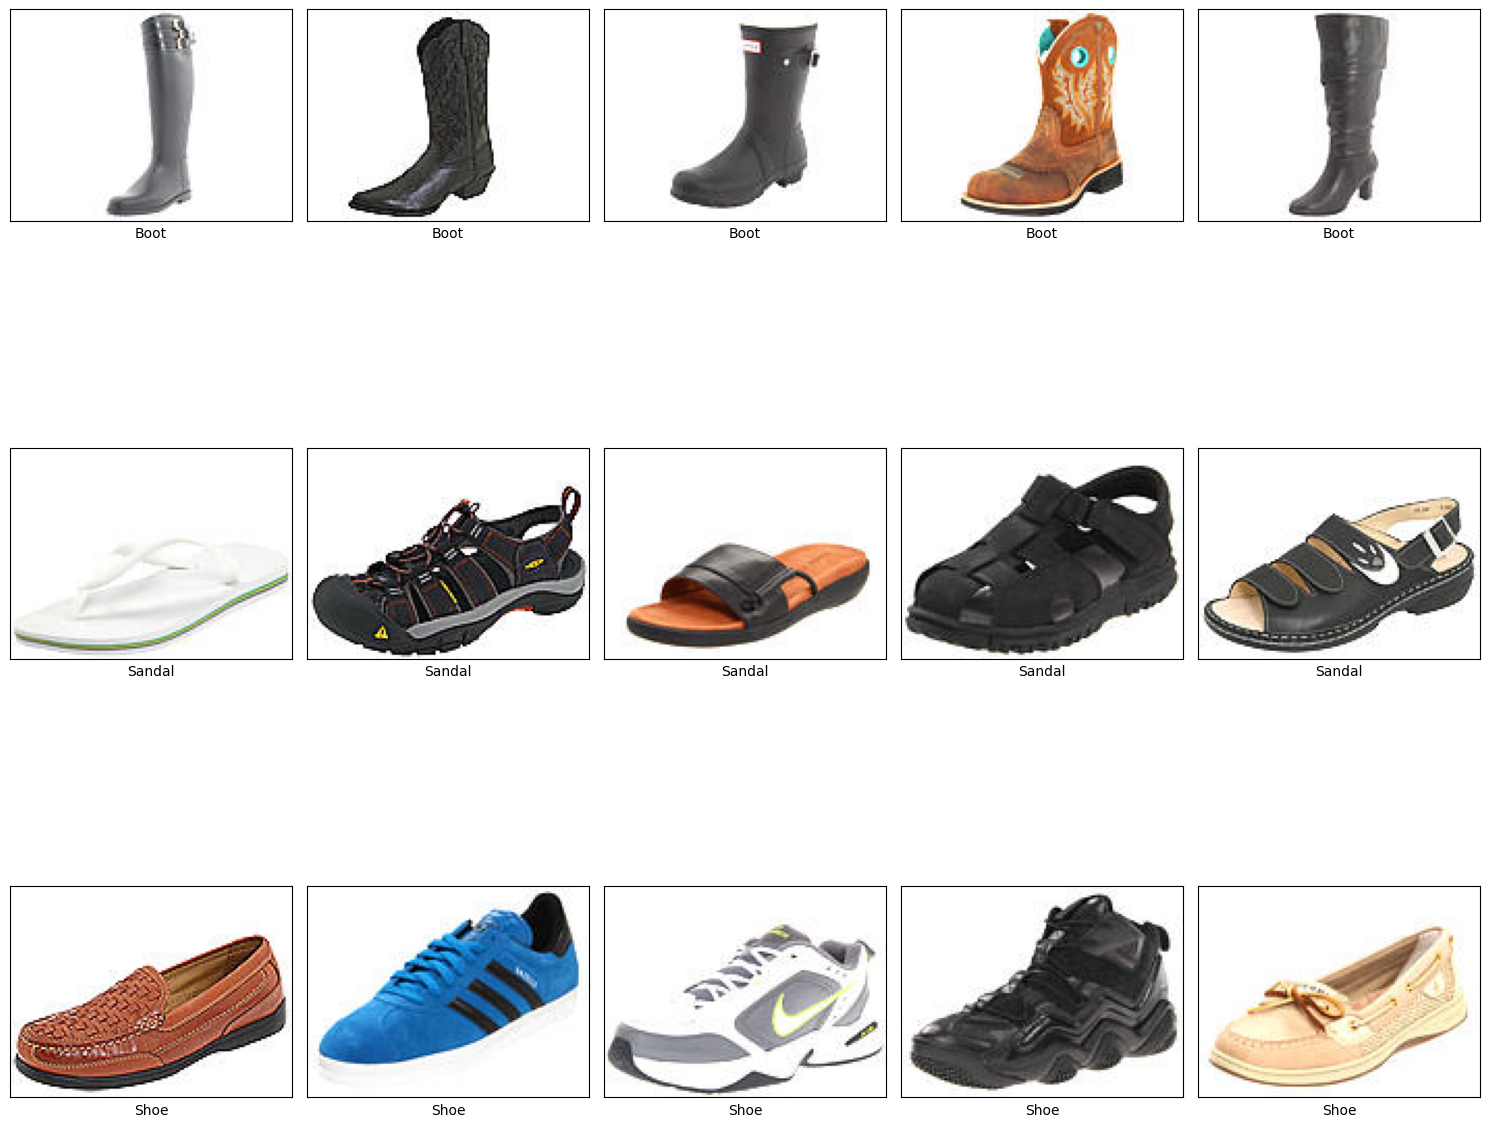

In [5]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
footwear_image = {}

# Tentukan path sumber train
path = "./"  # Menggunakan direktori saat ini sebagai root
path_sub = os.path.join(path, "Footwear")  # Folder dataset langsung ada di root

for i in os.listdir(path_sub):
    footwear_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(footwear_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(footwear_image.keys()):  # Gunakan kunci dari kamus
    images = np.random.choice(footwear_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)  # Tidak dikonversi ke grayscale
        axs[i, j].imshow(img)  # Tidak menggunakan cmap='gray'
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

Jumlah gambar di setiap kelas:
labels
Boot      1000
Sandal    1000
Shoe      1000
Name: count, dtype: int64


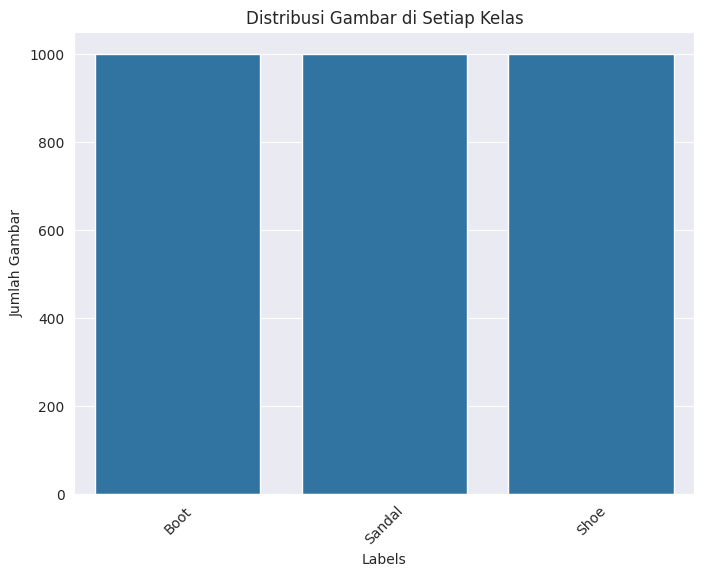

In [6]:
# Definisikan path sumber
footwear_path = "Footwear"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(footwear_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Hitung jumlah gambar per kelas
label_counts = distribution_train['labels'].value_counts()

# Tampilkan jumlah gambar per kelas dalam bentuk tabel
print("Jumlah gambar di setiap kelas:")
print(label_counts)

# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Labels")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.title("Distribusi Gambar di Setiap Kelas")
plt.show()

#### Split Dataset

In [7]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Footwear'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Footwear"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"



set    labels
test   Boot      192
       Sandal    204
       Shoe      204
train  Boot      808
       Sandal    796
       Shoe      796
dtype: int64 


                                  path  labels    set
534   Footwear/Sandal/Sandal (453).jpg  Sandal  train
1085      Footwear/Boot/boot (676).jpg    Boot  train
2134      Footwear/Boot/boot (727).jpg    Boot  train
2717      Footwear/Shoe/Shoe (135).jpg    Shoe   test
12        Footwear/Boot/boot (724).jpg    Boot  train


In [8]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [9]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_boot = os.path.join(TRAIN_DIR + '/Boot')
train_sandal = os.path.join(TRAIN_DIR + '/Sandal')
train_shoe = os.path.join(TRAIN_DIR + '/Shoe')

test_boot = os.path.join(TEST_DIR + '/Boot')
test_sandal = os.path.join(TEST_DIR + '/Sandal')
test_shoe = os.path.join(TEST_DIR + '/Shoe')

print("Total number of boot images in training set: ", len(os.listdir(train_boot)))
print("Total number of sandal images in training set: ", len(os.listdir(train_sandal)))
print("Total number of shoe images in training set: ", len(os.listdir(train_shoe)))

print("Total number of boot images in test set: ", len(os.listdir(test_boot)))
print("Total number of sandal images in test set: ", len(os.listdir(test_sandal)))
print("Total number of shoe images in test set: ", len(os.listdir(test_shoe)))

Total number of boot images in training set:  808
Total number of sandal images in training set:  796
Total number of shoe images in training set:  796
Total number of boot images in test set:  192
Total number of sandal images in test set:  204
Total number of shoe images in test set:  204


### Valid Split

In [10]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

# Test set tidak boleh pakai subset
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)


Found 1921 images belonging to 3 classes.
Found 479 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [11]:
# Cek jumlah batch yang tersedia
print(f"Total batches in train set: {len(train_generator)}")
print(f"Total batches in validation set: {len(validation_generator)}")

# Pastikan steps_per_epoch sesuai jumlah batch di train set
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

Total batches in train set: 61
Total batches in validation set: 15


## Modelling

In [12]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
# Hyperparameter for L2 Regularization
# lambda_value = 0.01  # Anda bisa mencoba 0.001 atau 0.0001 jika terlalu besar

model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3),
                   padding='same',
                   activation='relu',
                  #  kernel_regularizer=l2(lambda_value),
                   input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3),
                   padding='same',
                   activation='relu',
                  #  kernel_regularizer=l2(lambda_value))
                    ))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3),
                   padding='same',
                   activation='relu',
                  #  kernel_regularizer=l2(lambda_value)
                   ))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 1nd Dense Layer
model_1.add(Dense(64,
                  activation = 'relu',
                  # kernel_regularizer=l2(lambda_value)
                  ))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(3, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         663,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,587 (2.61 MB)

 Trainable params: 683,395 (2.61 MB)

 Non-trainable params: 192 (768.00 B)

None


In [13]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

history_1 = model_1.fit(
    train_generator,
    epochs=100,  # Bisa dikurangi jika overfitting
    validation_data=validation_generator,
    callbacks=[callback_model(), lr_scheduler]
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5305 - loss: 1.8726 - val_accuracy: 0.5094 - val_loss: 0.9917 - learning_rate: 1.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7354 - loss: 0.6333 - val_accuracy: 0.3737 - val_loss: 0.9550 - learning_rate: 1.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8093 - loss: 0.4548 - val_accuracy: 0.4008 - val_loss: 0.9460 - learning_rate: 1.0000e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8508 - loss: 0.3992 - val_accuracy: 0.6931 - val_loss: 0.6649 - learning_rate: 1.0000e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8629 - loss: 0.3577 - val_accuracy: 0.7474 - val_loss: 0.5971 - learning_rate: 1.0000e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8883 - loss: 0.3087 - val_accuracy: 0.8998 - val_loss: 0.3486 - learning_rate: 1.0000e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9098 - los

## Evaluasi dan Visualisasi

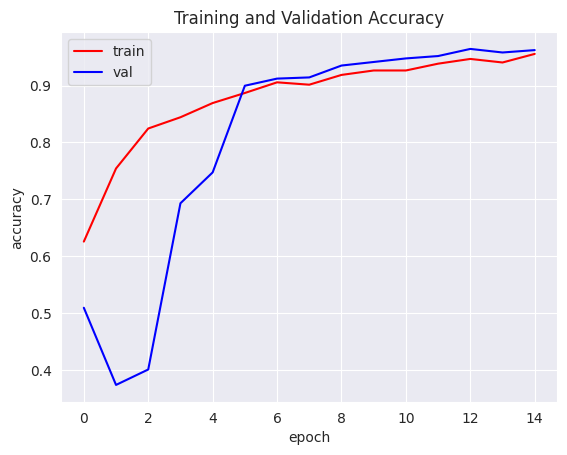

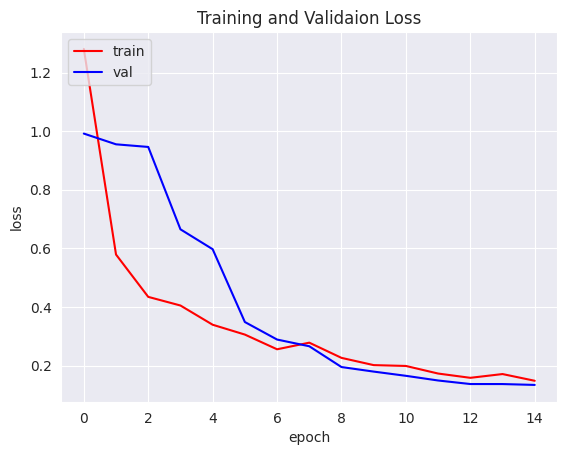

In [14]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## Konversi Model

### save model

In [15]:
save_path = './saved_model_Anna'
tf.saved_model.save(model_1, save_path)

In [18]:
# Compress the folder
shutil.make_archive('./saved_model_Anna', 'zip', './saved_model_Anna')

# Download the compressed file
files.download('./saved_model_Anna')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TFLite

In [19]:
# Konversi model_1 ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Simpan model dalam format .tflite
tflite_model_path = "./model_Anna.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil disimpan dalam format TensorFlow Lite (TFLite).")

# Buat folder untuk menyimpan file TFLite sebelum dikompres
tflite_dir = "./model_Anna_tflite"
os.makedirs(tflite_dir, exist_ok=True)

# Pindahkan file TFLite ke dalam folder
shutil.copy2(tflite_model_path, tflite_dir)

# Kompres folder TFLite ke ZIP
shutil.make_archive(tflite_dir, 'zip', tflite_dir)

# Unduh file ZIP
files.download(f"{tflite_dir}.zip")

Saved artifact at '/tmp/tmpnbq2u3hx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133422431236944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133422431238096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133422431237520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133422431238288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133422431238480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133422431236560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133422431239440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133422431237136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133423951987920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133423951988496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13342395198753

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TFJS

In [20]:
import tensorflowjs as tfjs

# Simpan model_1 dalam format TensorFlow.js
tfjs_target_dir = "./model_Anna_tfjs"
tfjs.converters.save_keras_model(model_1, tfjs_target_dir)

print("✅ Model berhasil disimpan dalam format TensorFlow.js!")

# Kompres folder TFJS
shutil.make_archive('./model_Anna_tfjs', 'zip', './model_Anna_tfjs')

# Unduh file ZIP
files.download('./model_Anna_tfjs.zip')


failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model berhasil disimpan dalam format TensorFlow.js!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
pip freeze > requirements.txt

## Inference (Optional)